In [1]:
"""
Created on Tue Aug 9 12:34:06 2020
@author: vxr131730 - Venkatraman Renganathan

This script simulates WMSR Consensus Algorithm and its failure due to spoofing
This script is tested in Python 3.7, Windows 10, 64-bit
(C) Venkatraman Renganathan, 2020.  Email: vrengana@utdallas.edu

This program is a free software: you can redistribute it and/or modify it
under the terms of the GNU lesser General Public License, either version 
3.7, or any later version. This program is distributed in the hope that it 
will be useful, but WITHOUT ANY WARRANTY. 
"""

##################### IMPORT ALL THE REQUIRED LIBRARIES #######################
import numpy as np
import random
import matplotlib.pyplot as plt

## Running W-MSR on (4,4) robust graph with F = 3
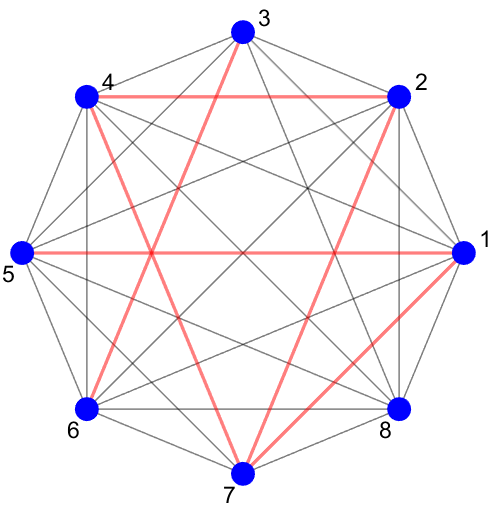

In [2]:
def WMSR(N, T, F, x0, A):
    """
    Function WMSR updates the information state of each agents after removing extreme values from its in-neighbors
    Input Parameters:
    N  : Number of agents
    T  : Time Span 
    F  : Number of malicious agents
    x0 : Initial value of agents
    A  : Graph Adjacency Matrix
    """   
    # Define Data
    x = np.zeros((T+1,N))
    
    maliciousIndex1  = 0 
    maliciousIndex2  = 3
    maliciousIndex3  = 6
    maliciousIndices = [maliciousIndex1, maliciousIndex2, maliciousIndex3]
    
    # Set values of all vehicles at time = 0 to x_0
    x[0,:] = x0
    
    # Set malicious node value to random value
    x[:,maliciousIndex1] = 0        
    x[:,maliciousIndex2] = 1
    x[:,maliciousIndex3] = 2
    
    for k in range(T):        
        for i in range(N):
            
            # Node @ maliciousIndex is malicious, so don't update that index
            if i in maliciousIndices:
                continue
            
            # Extract the i^{th} row
            A_i_row    = A[:,i]                 
            beforeSort = np.column_stack((x[k,:].T, A_i_row.T))            
            
            # Extract only in-neighbors                            
            beforeSort = beforeSort[np.where(beforeSort[:,1] == 1),0][0,:]    
            d_i        = len(beforeSort) # Number of in-neighbors
                    
            # Removing larger values - sort descendingly
            ascendSort = np.sort(beforeSort)
            ascendSort = ascendSort[::-1]
            # Get the indices where it is greater than x[k]
            indices    = np.argwhere(ascendSort > x[k,i])
            indices    = indices[:,0]                        
            if indices.shape[0] < F:
                ascendSort = np.delete(ascendSort, indices)
                R_i        = len(indices)
            else:                
                ascendSort = np.delete(ascendSort, indices[0:F]) 
                R_i        = F
            
            # Removing smaller values   
            ascendSort = np.sort(ascendSort)            
            indices    = np.argwhere(ascendSort < x[k,i])
            indices    = indices[:,0]            
            if indices.shape[0] < F:
                ascendSort =  np.delete(ascendSort, indices)
                R_i        += len(indices)
            else:                
                ascendSort =  np.delete(ascendSort, indices[0:F])  
                R_i        += F
            
            weight = 1/(len(ascendSort)+1)            
            weight = 1/(d_i - R_i + 1)            
            
            # WMSR Update
            x[k+1,i] = np.sum(weight*ascendSort) + weight* x[k,i]               
            
    return x

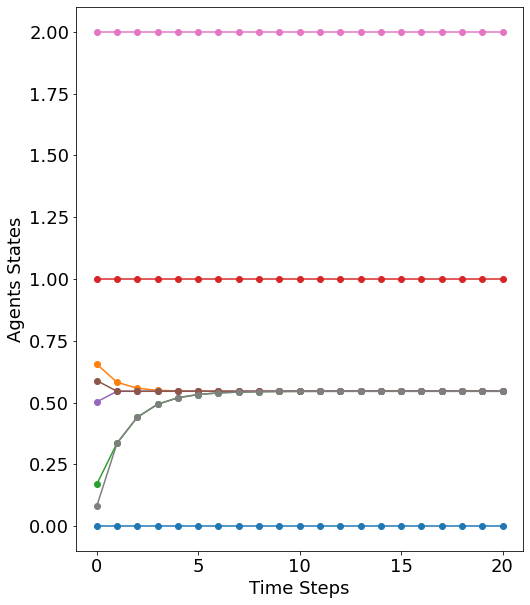

In [3]:
###############################################################################
######################  MAIN SIMULATION  ######################################
###############################################################################  

T  = 20                   # Time Span 
F  = 3                    # Number of malicious agents    

A = np.array([[0, 1, 1, 1, 1, 1],
              [1, 0, 1, 1, 1, 1],
              [1, 1, 0, 1, 1, 1],
              [1, 1, 1, 0, 1, 1],
              [1, 1, 1, 1, 0, 1],
              [1, 1, 1, 1, 1, 0]]) # This is a (3,3) robust graph

A = np.array([[0, 1, 1, 1, 1, 1, 1, 1],
              [1, 0, 1, 1, 1, 1, 1, 1],
              [1, 1, 0, 1, 1, 1, 0, 1],
              [1, 1, 1, 0, 1, 1, 1, 1],
              [1, 1, 1, 1, 0, 1, 1, 1],
              [1, 1, 1, 1, 1, 0, 1, 1],
              [1, 1, 0, 1, 1, 1, 0, 1],
              [1, 1, 1, 1, 1, 1, 1, 0]]) # This is a (4,4) robust graph

# Initial State Values for all N agents 
x0 = np.random.rand(A.shape[0])
N, = x0.shape

# Get the Safe consensus updates for all time steps
x = WMSR(N, T, F, x0, A)    

# Plot the values
timeVector = np.arange(T+1)
plt.figure(figsize=(8,10))
plt.plot(timeVector, x, 'o-')
plt.xlabel("Time Steps", fontsize=18)
plt.ylabel("Agents States", fontsize=18)    
plt.tick_params(axis='both', labelsize=18)  

In [2]:
def GetSpoofedAdjacencyMatrix(A, idx):
    """
    Function GetSpoofedAdjacencyMatrix returns a new adjacency matrix with spoofing agent spoofing 1 agent
    
    Input Parameters:    
    A  : Graph Adjacency Matrix
    idx: Index of the spoofing agent
    """   
    
    # Get the size of the adjacency matix
    n = A.shape[0]
    
    A_new = np.zeros((n+1,n+1))
    
    # Fill the entries
    A_new[0:n, 0:n] = A    
    A_new[n,0:n]    = A[idx,:]
    A_new[0:n,n]    = A[:,idx]
    
    return A_new    

In [3]:
def Spoofed_WMSR(x, N, T, F, A, mals, spoof_indices):
    """
    Function Spoofed_WMSR updates the information state of each agents 
    by removing extreme values from its in-neighbors after spoofing.
    
    Input Parameters:
    x  : Data Structure to store history of agent values for all time steps
    N  : Number of agents
    T  : Time Span 
    F  : Number of malicious agents
    A  : Graph Adjacency Matrix
    mals: Indices of malicious nodes
    spoof_indices: ndices of spoofed nodes
    """   
    
    for k in range(T):        
        
        print('Agents values at time:', k, 'is', np.round_(x[k,:],2))
        
        for i in range(N):
            
            # Node #5 is malicious, so don't update that index
            if i in mals or i in spoof_indices:
                continue
            
            # Extract the i^{th} row
            A_i_row    = A[:,i]                 
            beforeSort = np.column_stack((x[k,:].T, A_i_row.T))            
            
            # Extract only in-neighbors                            
            beforeSort = beforeSort[np.where(beforeSort[:,1] == 1),0][0,:]            
                    
            # Removing larger values - sort descendingly
            ascendSort = np.sort(beforeSort)
            ascendSort = ascendSort[::-1]
            # Get the indices where it is greater than x[k]
            indices    = np.argwhere(ascendSort > x[k,i])
            indices    = indices[:,0]            
            if indices.shape[0] < F:
                ascendSort = np.delete(ascendSort, indices)
            else:                
                ascendSort = np.delete(ascendSort, indices[0:F])
            
            # Removing smaller values   
            ascendSort = np.sort(ascendSort)            
            indices    = np.argwhere(ascendSort < x[k,i])
            indices    = indices[:,0]            
            if indices.shape[0] < F:
                ascendSort = np.delete(ascendSort, indices)
            else:                
                ascendSort = np.delete(ascendSort, indices[0:F]) 
                
            if i == 1:
                print('Node 2 neighbors after WMSR:', np.round_(ascendSort,2))
            
            weight = 1/(len(ascendSort)+1)
            
            # WMSR Update
            x[k+1,i] = np.sum(weight*ascendSort) + weight* x[k,i] 
            
    return x

## Running W-MSR on the same (4,4) robust graph with F = 3 but with spoofing attack
### In the below simulation - change the value of variable "num_spoofs" and you will find the following observations
#### num_spoofs = 1: Resilient asymptotic consensus is acheived
#### num_spoofs = 2: Resilient asymptotic consensus is acheived
#### num_spoofs = 3, i.e., (F=3): Resilient asymptotic consensus is NOT acheived
#### num_spoofs >= 3: Resilient asymptotic consensus is NOT acheived

After spoofing there are 11 agents
At time 0, the node values are: [0.   0.74 0.76 1.   0.89 0.66 2.   0.99 0.   0.   0.  ]
Agents values at time: 0 is [0.   0.74 0.76 1.   0.89 0.66 2.   0.99 0.   0.   0.  ]
Node 2 neighbors after WMSR: [0.   0.66 0.76 0.89]
Agents values at time: 1 is [0.   0.61 0.54 1.   0.61 0.61 2.   0.67 0.   0.   0.  ]
Node 2 neighbors after WMSR: [0.   0.54 0.61 0.61]
Agents values at time: 2 is [0.   0.47 0.44 1.   0.47 0.47 2.   0.51 0.   0.   0.  ]
Node 2 neighbors after WMSR: [0.   0.44 0.47 0.47]
Agents values at time: 3 is [0.   0.37 0.35 1.   0.37 0.37 2.   0.4  0.   0.   0.  ]
Node 2 neighbors after WMSR: [0.   0.35 0.37 0.37]
Agents values at time: 4 is [0.   0.29 0.27 1.   0.29 0.29 2.   0.31 0.   0.   0.  ]
Node 2 neighbors after WMSR: [0.   0.27 0.29 0.29]
Agents values at time: 5 is [0.   0.23 0.21 1.   0.23 0.23 2.   0.24 0.   0.   0.  ]
Node 2 neighbors after WMSR: [0.   0.21 0.23 0.23]
Agents values at time: 6 is [0.   0.18 0.17 1.   0.18 0.18 2

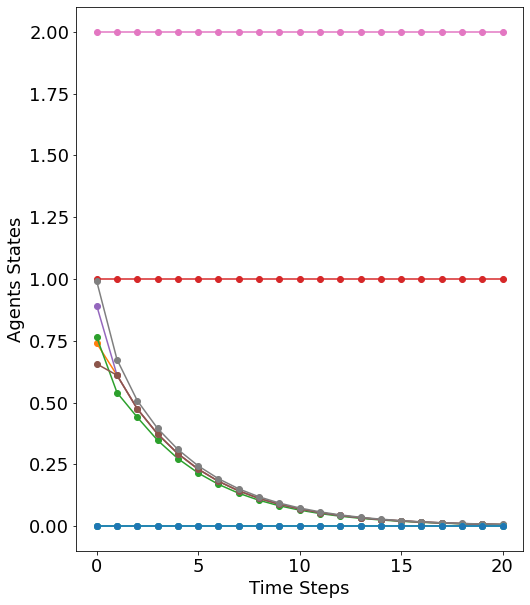

In [8]:
###############################################################################
######################  SPOOF SIMULATION  #####################################
###############################################################################  

T          = 20  # Time Span 
F          = 3   # Number of malicious agents    
num_spoofs = F   # Number of spoofed entities

# Adjacency Matrix
A = np.array([[0, 1, 1, 1, 1, 1],
              [1, 0, 1, 1, 1, 1],
              [1, 1, 0, 1, 1, 1],
              [1, 1, 1, 0, 1, 1],
              [1, 1, 1, 1, 0, 1],
              [1, 1, 1, 1, 1, 0]]) # (3,3) robust graph
A = np.array([[0, 1, 1, 1, 1, 1, 1, 1],
              [1, 0, 1, 1, 1, 1, 1, 1],
              [1, 1, 0, 1, 1, 1, 0, 1],
              [1, 1, 1, 0, 1, 1, 1, 1],
              [1, 1, 1, 1, 0, 1, 1, 1],
              [1, 1, 1, 1, 1, 0, 1, 1],
              [1, 1, 0, 1, 1, 1, 0, 1],
              [1, 1, 1, 1, 1, 1, 1, 0]]) # This is a (4,4) robust graph

maliciousIndex1  = 0 
maliciousIndex2  = 3 
maliciousIndex3  = 6
maliciousIndices = [maliciousIndex1, maliciousIndex2, maliciousIndex3]
spoofingIndex    = maliciousIndex1

# Get the new adjacency matrix with the spoofed nodes
for i in range(num_spoofs):
    A = GetSpoofedAdjacencyMatrix(A,spoofingIndex)

# Get the new number of nodes
N = A.shape[0]
print('After spoofing there are', N, 'agents')

# Define Data
x = np.zeros((T+1,N))

# Set values of all vehicles at time = 0 to x_0
x[0,:] = np.random.rand(N)

# Set malicious nodes value to random value across all time steps
spoof_indices        = []
x[:,maliciousIndex1] = 0
x[:,maliciousIndex2] = 1
x[:,maliciousIndex3] = 2
for i in range(num_spoofs):
    spoof_indices.append(N-(i+1))
    x[:,N-(i+1)] = 0

print('At time 0, the node values are:', np.round_(x[0,:],2))

# Get the Safe consensus updates for all time steps
x = Spoofed_WMSR(x, N, T, F, A, maliciousIndices, spoof_indices)    

# Plot the values
timeVector = np.arange(T+1)
plt.figure(figsize=(8,10))
plt.plot(timeVector, x, 'o-')
plt.xlabel("Time Steps", fontsize=18)
plt.ylabel("Agents States", fontsize=18)    
plt.tick_params(axis='both', labelsize=18)  